In [1]:
import numpy as np
import tensorflow as tf
print(tf.__version__)

import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform

import keras 
from keras.callbacks import ReduceLROnPlateau

#CUDA_VISIBLE_DEVICES=0

2.9.1


In [2]:
#Laptop
#data_path = r'C:\Users\andyg\Documents\ECE 499 - CV Project\Git\Emotion_Recognition_Via_MLMethods\Data\Numpy Arrays'

#Desktop
data_path = r'C:\Users\Andy Guevara\Projects\ECE499_Emotions _Classifier\Emotion_Recognition_Via_MLMethods\Data\Numpy Arrays'

#Desktop - Lite
#data_path = r'C:\Users\Andy Guevara\Projects\ECE499_Emotions _Classifier\Emotion_Recognition_Via_MLMethods\Data\Np Arrays Lite'

X_train = np.load(data_path+'\\'+'X_train.npy')
#X_test = np.load(data_path+'\\'+'X_test.npy')
X_val = np.load(data_path+'\\'+'X_val.npy')
y_train = np.load(data_path+'\\'+'y_train.npy')
#y_test = np.load(data_path+'\\'+'y_test.npy')
y_val = np.load(data_path+'\\'+'y_val.npy')

print(X_train.shape, y_train.shape)

(35744, 120, 300) (35744,)


In [3]:
X_train = np.expand_dims(X_train,-1)
X_val = np.expand_dims(X_val,-1)
X_train[0].shape

(120, 300, 1)

In [4]:
#Data Loader
#https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
#https://satvik-venkatesh.github.io/blog-posts/data-gen-keras.html
#https://numpy.org/doc/stable/reference/generated/numpy.savez.html - use npz file ??

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator()

val_datagen = ImageDataGenerator()

train_datagen.fit(X_train)
val_datagen.fit(X_val)

width = 300
height = 120
num_classes = 8

In [5]:
def identity_block(X, f, filters, stage, block):

  '''
  Implementation of identity block described above

  Arguments:
  X -       input tensor to the block of shape (m, n_H_prev, n_W_prev, n_C_prev)
  f -       defines shpae of filter in the middle layer of the main path
  filters - list of integers, defining the number of filters in each layer of the main path
  stage -   defines the block position in the network
  block -   used for naming convention

  Returns: 
  X - output is a tensor of shape (n_H, n_W, n_C) which matches (m, n_H_prev, n_W_prev, n_C_prev)
  '''

  # defining base name for block
  conv_base_name = 'res' + str(stage) + block + '_'
  bn_base_name = 'bn' + str(stage) + block + '_'

  # retrieve number of filters in each layer of main path
  # NOTE: f3 must be equal to n_C. That way dimensions of the third component will match the dimension of original input to identity block
  f1, f2, f3 = filters

  # Batch normalization must be performed on the 'channels' axis for input. It is 3, for our case
  bn_axis = 3

  # save input for "addition" to last layer output; step in skip-connection
  X_skip_connection = X

  # ----------------------------------------------------------------------
  # Building layers/component of identity block using Keras functional API

  # First component/layer of main path
  X = Conv2D(filters= f1, kernel_size = (1,1), strides = (1,1), padding='valid', name=conv_base_name+'first_component', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=bn_axis, name=bn_base_name+'first_component')(X)
  X = Activation('relu')(X)
  
  # Second component/layer of main path
  X = Conv2D(filters= f2, kernel_size = (f,f), strides = (1,1), padding='same', name=conv_base_name+'second_component', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=bn_axis, name=bn_base_name+'second_component')(X)
  X = Activation('relu')(X)

  # Third component/layer of main path
  X = Conv2D(filters= f3, kernel_size = (1,1), strides = (1,1), padding='valid', name=conv_base_name+'third_component', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=bn_axis, name=bn_base_name+'third_component')(X)
  
  # "Addition step" - skip-connection value merges with main path
  # NOTE: both values have same dimensions at this point, so no operation is required to match dimensions
  X = Add()([X, X_skip_connection])
  X = Activation('relu')(X)

  return X

In [6]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in above figure
    
    Arguments:
    X -       input tensor to the block of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -       defines shape of filter in the middle layer of the main path
    filters - list of integers, defining the number of filters in each layer of the main path
    stage -   defines the block position in the network
    block -   used for naming convention
    s -       specifies the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining base name for block
    conv_base_name = 'res' + str(stage) + block + '_'
    bn_base_name = 'bn' + str(stage) + block + '_'
    
    # retrieve number of filters in each layer of main path
    f1, f2, f3 = filters
    
    # Batch normalization must be performed on the 'channels' axis for input. It is 3, for our case
    bn_axis = 3

    # save input for "addition" to last layer output; step in skip-connection
    X_skip_connection = X

    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(f1, (1, 1), strides = (s,s), padding = 'valid', name = conv_base_name + 'first_component', kernel_initializer = glorot_uniform(seed=0), kernel_regularizer=regularizers.l2(0.001))(X)
    X = BatchNormalization(axis = bn_axis, name = bn_base_name + 'first_component')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(f2,  kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_base_name + 'second_component', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = bn_axis, name = bn_base_name + 'second_component')(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(f3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_base_name + 'third_component', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = bn_axis, name = bn_base_name + 'third_component')(X)

    ##### Convolve skip-connection value to match its dimensions to third layer output's dimensions #### 
    X_skip_connection = Conv2D(f3, (1, 1), strides = (s,s), padding = 'valid', name = conv_base_name + 'merge', kernel_initializer = glorot_uniform(seed=0))(X_skip_connection)
    X_skip_connection = BatchNormalization(axis = 3, name = bn_base_name + 'merge')(X_skip_connection)

    # "Addition step" 
    # NOTE: both values have same dimensions at this point
    X = Add()([X, X_skip_connection])
    X = Activation('relu')(X)

    return X

In [7]:
#From: https://colab.research.google.com/github/yashclone999/ResNet_MODEL/blob/master/ResNet50.ipynb#scrollTo=KAA3cR4A-kG0
def ResNet50(input_shape = (120, 300, 1), classes = 8):
    """
    Arguments:
    input_shape - shape of the images of the dataset
    classes - number of classes

    Returns:
    model - a Model() instance in Keras
    
    """
    
    # plug in input_shape to define the input tensor
    X_input = Input(input_shape)

    # Zero-Padding : pads the input with a pad of (3,3)
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv_1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # NOTE: dimensions of filters that are passed to identity block are such that final layer output
    # in identity block mathces the original input to the block
    # blocks in each stage are alphabetically sequenced

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    X = layers.Dropout(0.5)(X)

    # Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')
    X = layers.Dropout(0.5)(X)

    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
    X = layers.Dropout(0.7)(X)

    # Stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    X = layers.Dropout(0.7)(X)

    # Average Pooling
    X = AveragePooling2D((2, 2), name='avg_pool')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    #X = layers.Dropout(0.8)(X)
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [8]:
optim = tf.keras.optimizers.Adam(learning_rate=0.01)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
#loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
#loss = tf.keras.losses.KLDivergence()

save_path = r'C:\Users\Andy Guevara\Projects\ECE499_Emotions _Classifier\Emotion_Recognition_Via_MLMethods\Emotions Classifier\Model\dummy_model'

reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, min_lr=0.001)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_path, monitor='val_accuracy', save_best_only=True, initial_value_threshold = 0.4)

model = ResNet50()
model.compile(optimizer=optim, loss=loss, metrics=['accuracy'])

In [9]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 300, 1  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 126, 306, 1)  0          ['input_1[0][0]']                
                                                                                                  
 conv_1 (Conv2D)                (None, 60, 150, 64)  3200        ['zero_padding2d[0][0]']         
                                                                                                  
 bn_1 (BatchNormalization)      (None, 60, 150, 64)  256         ['conv_1[0][0]']          

In [10]:
nb_epochs = 100

history = model.fit(train_datagen.flow(X_train, y_train, batch_size=32),
         validation_data=val_datagen.flow(X_val, y_val, batch_size=8),
         epochs=nb_epochs, callbacks=[reduce_lr,checkpoint])

Epoch 1/100
1117/1117 [==============================] - 354s 301ms/step - loss: 6.2939 - accuracy: 0.1315 - val_loss: 8.2486 - val_accuracy: 0.1257 - lr: 0.0100
Epoch 2/100
1117/1117 [==============================] - 329s 294ms/step - loss: 2.2876 - accuracy: 0.1405 - val_loss: 2.2126 - val_accuracy: 0.1266 - lr: 0.0100
Epoch 3/100
1117/1117 [==============================] - 255s 228ms/step - loss: 2.2054 - accuracy: 0.1404 - val_loss: 2.2998 - val_accuracy: 0.1612 - lr: 0.0100
Epoch 4/100
1117/1117 [==============================] - 266s 238ms/step - loss: 2.1819 - accuracy: 0.1470 - val_loss: 7.1405 - val_accuracy: 0.0979 - lr: 0.0100
Epoch 5/100
1117/1117 [==============================] - 284s 254ms/step - loss: 2.2303 - accuracy: 0.1477 - val_loss: 2.1119 - val_accuracy: 0.1091 - lr: 0.0100
Epoch 6/100
1117/1117 [==============================] - 329s 295ms/step - loss: 2.1482 - accuracy: 0.1553 - val_loss: 2.9468 - val_accuracy: 0.0970 - lr: 0.0100
Epoch 7/100
1117/1117 [=====

INFO:tensorflow:Assets written to: C:\Users\Andy Guevara\Projects\ECE499_Emotions _Classifier\Emotion_Recognition_Via_MLMethods\Emotions Classifier\Model\dummy_model\assets


INFO:tensorflow:Assets written to: C:\Users\Andy Guevara\Projects\ECE499_Emotions _Classifier\Emotion_Recognition_Via_MLMethods\Emotions Classifier\Model\dummy_model\assets


1117/1117 [==============================] - 287s 257ms/step - loss: 1.4411 - accuracy: 0.4670 - val_loss: 1.6657 - val_accuracy: 0.4054 - lr: 0.0010
Epoch 46/100
1117/1117 [==============================] - 260s 232ms/step - loss: 1.4228 - accuracy: 0.4723 - val_loss: 1.6797 - val_accuracy: 0.3979 - lr: 0.0010
Epoch 47/100
1117/1117 [==============================] - 268s 240ms/step - loss: 1.4048 - accuracy: 0.4775 - val_loss: 2.0881 - val_accuracy: 0.3071 - lr: 0.0010
Epoch 48/100
1117/1117 [==============================] - ETA: 0s - loss: 1.3839 - accuracy: 0.4865

INFO:tensorflow:Assets written to: C:\Users\Andy Guevara\Projects\ECE499_Emotions _Classifier\Emotion_Recognition_Via_MLMethods\Emotions Classifier\Model\dummy_model\assets


INFO:tensorflow:Assets written to: C:\Users\Andy Guevara\Projects\ECE499_Emotions _Classifier\Emotion_Recognition_Via_MLMethods\Emotions Classifier\Model\dummy_model\assets


1117/1117 [==============================] - 268s 240ms/step - loss: 1.3839 - accuracy: 0.4865 - val_loss: 1.6694 - val_accuracy: 0.4079 - lr: 0.0010
Epoch 49/100
1117/1117 [==============================] - 252s 226ms/step - loss: 1.3672 - accuracy: 0.4892 - val_loss: 1.7466 - val_accuracy: 0.3704 - lr: 0.0010
Epoch 50/100
1117/1117 [==============================] - 252s 226ms/step - loss: 1.3446 - accuracy: 0.5006 - val_loss: 1.6816 - val_accuracy: 0.3951 - lr: 0.0010
Epoch 51/100
1117/1117 [==============================] - ETA: 0s - loss: 1.3266 - accuracy: 0.5069

INFO:tensorflow:Assets written to: C:\Users\Andy Guevara\Projects\ECE499_Emotions _Classifier\Emotion_Recognition_Via_MLMethods\Emotions Classifier\Model\dummy_model\assets


INFO:tensorflow:Assets written to: C:\Users\Andy Guevara\Projects\ECE499_Emotions _Classifier\Emotion_Recognition_Via_MLMethods\Emotions Classifier\Model\dummy_model\assets


1117/1117 [==============================] - 268s 240ms/step - loss: 1.3266 - accuracy: 0.5069 - val_loss: 1.6729 - val_accuracy: 0.4181 - lr: 0.0010
Epoch 52/100
1117/1117 [==============================] - 253s 226ms/step - loss: 1.3005 - accuracy: 0.5176 - val_loss: 1.7955 - val_accuracy: 0.3867 - lr: 0.0010
Epoch 53/100
1117/1117 [==============================] - 253s 227ms/step - loss: 1.2677 - accuracy: 0.5298 - val_loss: 2.0984 - val_accuracy: 0.3056 - lr: 0.0010
Epoch 54/100
1117/1117 [==============================] - 253s 226ms/step - loss: 1.2485 - accuracy: 0.5353 - val_loss: 1.7882 - val_accuracy: 0.3976 - lr: 0.0010
Epoch 55/100
1117/1117 [==============================] - 253s 226ms/step - loss: 1.2131 - accuracy: 0.5520 - val_loss: 1.9379 - val_accuracy: 0.3436 - lr: 0.0010
Epoch 56/100
1117/1117 [==============================] - 300s 269ms/step - loss: 1.1857 - accuracy: 0.5577 - val_loss: 1.9343 - val_accuracy: 0.3711 - lr: 0.0010
Epoch 57/100
1117/1117 [===========

KeyboardInterrupt: 

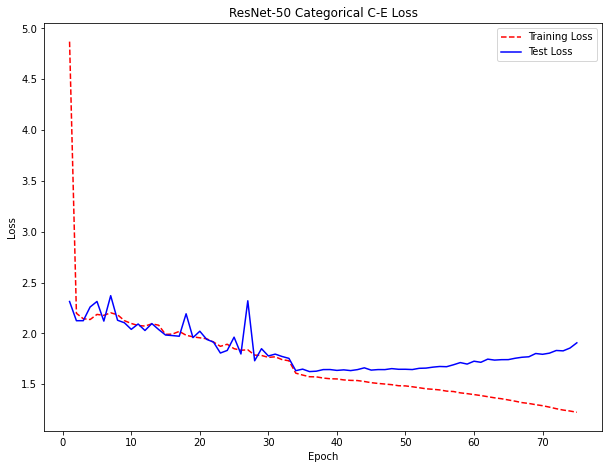

In [ ]:
import matplotlib.pyplot as plt
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize=(10,7.5))
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
#plt.ylim(-0.5,5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNet-50 Categorical C-E Loss')
plt.show()

In [ ]:
X_test = np.load(data_path+'\\'+'X_test.npy')
y_test = np.load(data_path+'\\'+'y_test.npy')
model.evaluate(X_test, y_test)

MemoryError: Unable to allocate 944. MiB for an array with shape (123696000,) and data type float64

In [13]:
model.save(save_path)